In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from encoding_information.gpu_utils import limit_gpu_memory_growth  
limit_gpu_memory_growth()

import matplotlib.pyplot as plt
from bsccm import BSCCM
import time
from tqdm import tqdm
from cleanplots import *
# from led_array.bsccm_util import get_display_channel_names

import numpy as np
import jax.numpy as jnp
from scipy.stats import poisson
from matplotlib.patches import Circle
# from led_array.bsccm_utils import *
# from plot_utils import *
# from image_utils import add_shot_noise
from encoding_information.image_utils import *
from encoding_information.bsccm_utils import *
from scipy.ndimage import median_filter
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')



Opening BSCCM
Opened BSCCM


# Clean and noisy images

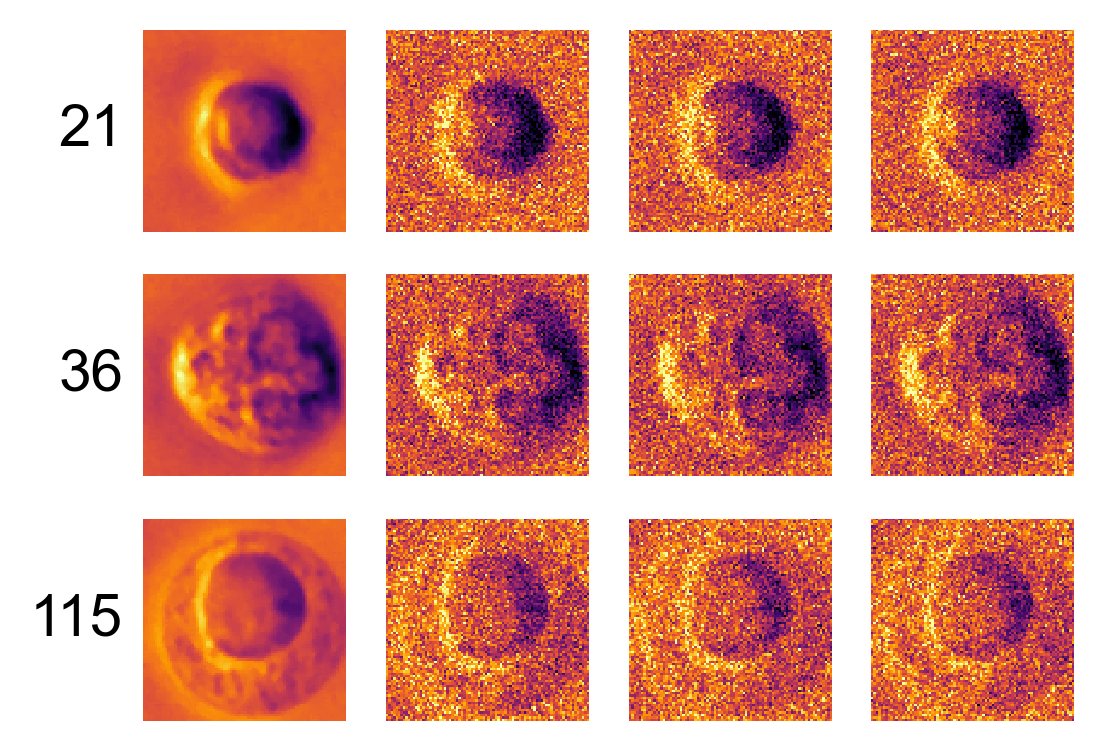

In [5]:
# indices = [37, 24, 0] # These ones are good for showing encoders in LED array and DPC (figure 1)
indices = [21, 36, 115] # these have images that look different

# read the three images in DPC_Right contrast
images = load_bsccm_images(bsccm, 'DPC_Right', indices=indices, convert_units_to_photons=True, median_filter=True,
                           edge_crop=22)

# get vmin and vmax for all images
vmin = np.min(images)
vmax = np.max(images)

# make a 3 x4 plot
fig, ax = plt.subplots(len(indices), 4, figsize=(4, len(indices)), dpi=300)
# first column in noiseless images
for i in range(len(images)):
    ax[i, 0].imshow(images[i], cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax[i, 0].axis('off')
    ax[i, 0].text(-0.1, 0.5, '{}'.format((indices[i])), va='center', ha='right', transform=ax[i, 0].transAxes)

# next three columns are noisy images
for i in range(len(images)):
    for j in range(3):
        # add shot noise
        frac = .015
        noisy = add_noise(images[i] * frac)
        ax[i, j+1].imshow(noisy, cmap='inferno', interpolation='nearest', vmin=vmin * frac, vmax=vmax * frac)
        ax[i, j+1].axis('off')


fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'clean_and_noisy_images' + '.pdf', transparent=True, dpi=600)

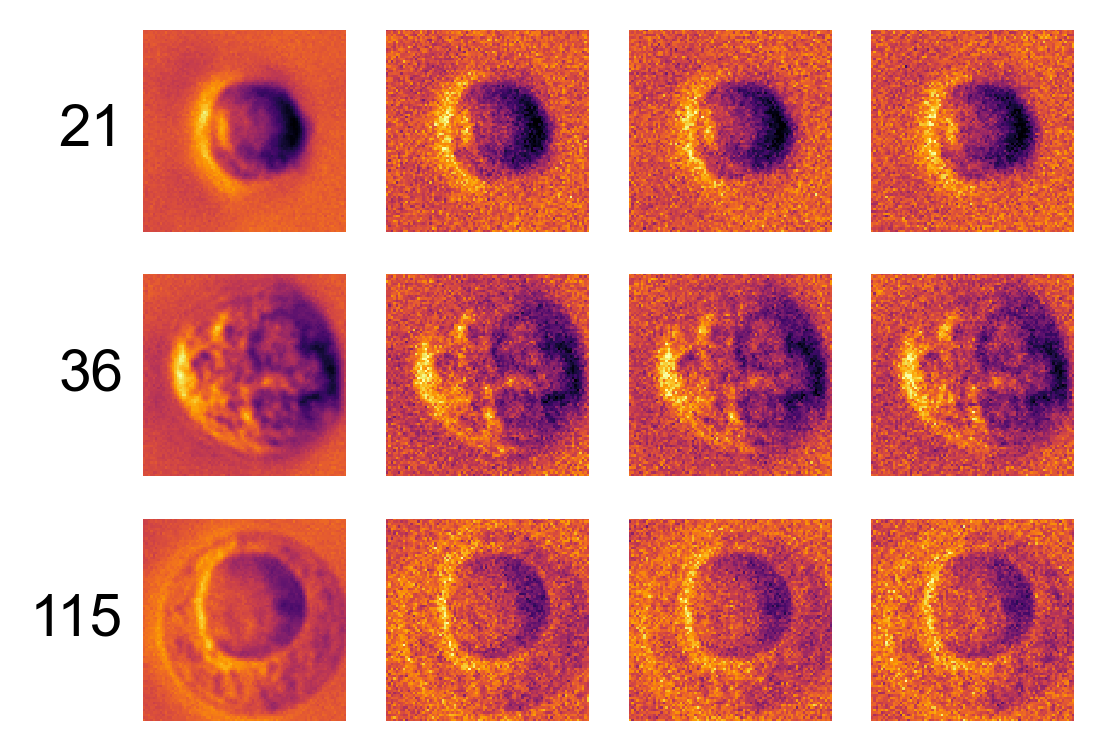

In [6]:
# indices = [37, 24, 0] # These ones are good for showing encoders in LED array and DPC (figure 1)
indices = [21, 36, 115] # these have images that look different

# read the three images in DPC_Right contrast
images = load_bsccm_images(bsccm, 'DPC_Right', indices=indices, convert_units_to_photons=True, median_filter=False,
                           edge_crop=22)

# get vmin and vmax for all images
vmin = np.min(images)
vmax = np.max(images)

# make a 3 x4 plot
fig, ax = plt.subplots(len(indices), 4, figsize=(4, len(indices)), dpi=300)
# first column in noiseless images
for i in range(len(images)):
    ax[i, 0].imshow(images[i], cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax[i, 0].axis('off')
    ax[i, 0].text(-0.1, 0.5, '{}'.format((indices[i])), va='center', ha='right', transform=ax[i, 0].transAxes)

# next three columns are noisy images
for i in range(len(images)):
    for j in range(3):
        # add shot noise
        frac = .05
        noisy = add_noise(images[i] * frac)
        ax[i, j+1].imshow(noisy, cmap='inferno', interpolation='nearest', vmin=vmin * frac, vmax=vmax * frac)
        ax[i, j+1].axis('off')


fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'clean_and_noisy_images_no_med_filter' + '.pdf', transparent=True, dpi=600)

# Visualize encoders in intensity space and image space

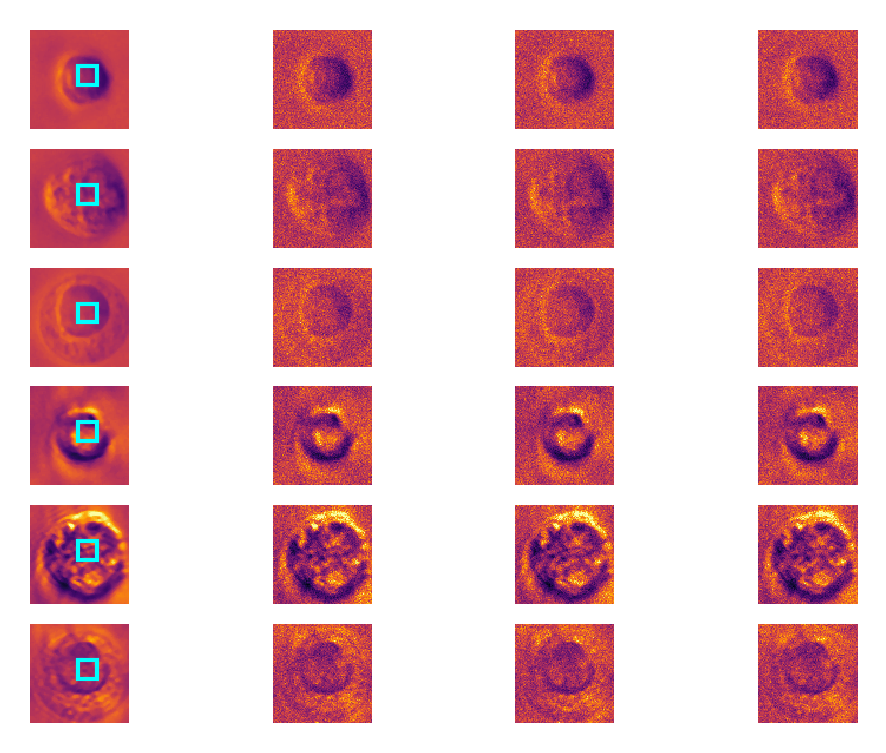

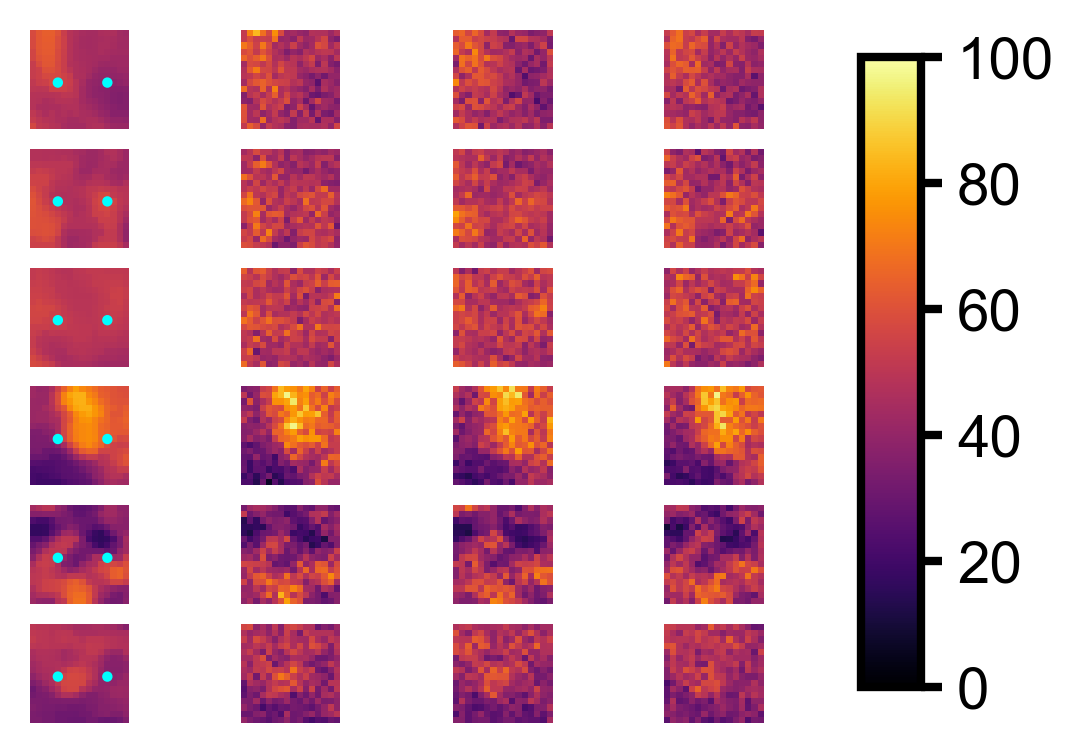

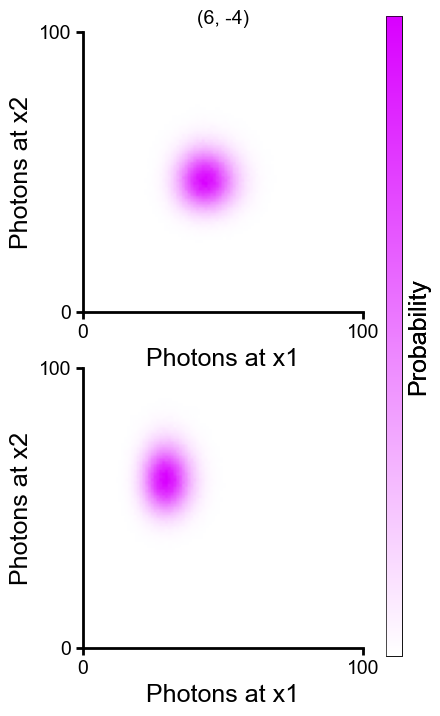

In [3]:
from jax import random
from encoding_information.plot_utils import plot_intensity_coord_histogram

num_randoms = int(1e6)

indices = [21, 36, 115] # these are different looking cells
vmin, vmax = 10, 40
mean_photons_per_pixel = 25

vmin, vmax = 0, 100
mean_photons_per_pixel = 50

x1 = (4, 8)
x2 = (12, 8)

offset = (6, -4)
# offset = (5, 5)

# for offset_x in tqdm(range(-10, 10, 2)):
#     for offset_y in range(-10, 10, 2):
# offset = (offset_y, offset_x)

def do_crop(image):
    # return image[image.shape[0] // 2 - 8:image.shape[0] // 2 + 8, image.shape[1] // 2 - 8: image.shape[1] // 2 + 8]
    return image[image.shape[0] // 2 - 8 + offset[0]:image.shape[0] // 2 + 8 + offset[0],
                    image.shape[1] // 2 - 8 + offset[1]: image.shape[1] // 2 + 8 + offset[1]]


# indices = [21, 38, 115] # these are different looking cells


channels = ['DPC_Right', 'LED119']


images_by_channel = {}
for channel in channels:
    images = load_bsccm_images(bsccm, channel, indices=indices, convert_units_to_photons=True, median_filter=True,
                        edge_crop=22)
    images = images * mean_photons_per_pixel / np.mean(images)
    images_by_channel[channel] = images

# take min and max across all images
# vmin = onp.percentile([onp.min(images) for images in images_by_channel.values()], 1)
# vmax = onp.percentile([onp.max(images) for images in images_by_channel.values()], 99)


# make a 3 x4 plot
fig, ax = plt.subplots(len(channels) * len(indices), 4, figsize=(4, len(indices)), dpi=300)
# first column in noiseless images
for i, channel in enumerate(channels):
    for j in range(len(images)):
        ax[i * 3 + j, 0].imshow(images_by_channel[channels[i]][j], cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax)
        ax[i * 3 + j, 0].axis('off')

        for k in range(3):
            noisy_image = add_noise(images_by_channel[channels[i]])
            ax[i * 3 + j, 1 + k].imshow(noisy_image[j], cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax)
            ax[i * 3 + j, 1 + k].axis('off')

        # draw a patch rectangle that shows the area being cropped using the offset
        rect = patches.Rectangle((noisy_image.shape[-2] // 2 - 8 + offset[0], noisy_image.shape[-1] // 2 - 8 + offset[1]), 16, 16,                    
                                linewidth=1, edgecolor='cyan', facecolor='none')
        
        ax[i * 3 + j, 0].add_patch(rect)
    
fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'good_bad_encoding_full_images' + '.pdf', transparent=True, dpi=600)


x1_values = {}
x2_values = {}
# crop to center 16x16 pixels and mkae the same plot
fig, ax = plt.subplots(len(channels) * len(indices), 4, figsize=(4, len(indices)), dpi=300)
# first column in noiseless images
for i, channel in enumerate(channels):
    x1_values[channel] = []
    x2_values[channel] = []
    for j in range(len(images)):
        image = images_by_channel[channels[i]][j]
        cropped_image = do_crop(image)
        x1_values[channel].append(cropped_image[x1])
        x2_values[channel].append(cropped_image[x2])

        ax[i * 3 + j, 0].imshow(cropped_image, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax)
        ax[i * 3 + j, 0].axis('off')
        # use patches to draw circles around the pixels
        ax[i * 3 + j, 0].add_patch(Circle(x1, 0.5, color='cyan', fill=True))
        ax[i * 3 + j, 0].add_patch(Circle(x2, 0.5, color='cyan', fill=True))

        for k in range(3):
            noisy_crop = add_noise(cropped_image)
            ax[i * 3 + j, 1 + k].imshow(noisy_crop, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax)
            ax[i * 3 + j, 1 + k].axis('off')



# make a single color bar for all images
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax[0, 0].get_images()[0], cax=cbar_ax)

fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'good_bad_encoding_image_crops' + '.pdf', transparent=True, dpi=600)

# plot the values of the two pixels
fig, ax = plt.subplots(2, 1, figsize=(4, 8))
bins = np.linspace(0, 2* mean_photons_per_pixel, 2 * mean_photons_per_pixel + 1)
for i, channel in enumerate(channels):
    x1_arr = np.array(x1_values[channel])
    x2_arr = np.array(x2_values[channel])
    rand_samples = random.poisson(random.PRNGKey(0), np.array([x1_arr, x2_arr])[..., None], shape=(2,) + x1_arr.shape + (num_randoms,))

    # plot a 2d histogram of the random samples
    # plot_intensity_coord_histogram(ax[i], rand_samples[0], rand_samples[1], bins=100, colors=
    #                             [get_color_cycle()[1], 
    #                                 get_color_cycle()[4],
    #                                 get_color_cycle()[3],    ],
    #                             max=100)

    plot_intensity_coord_histogram(ax[i], rand_samples[0, -2], rand_samples[1, -2], bins=100, colors=
                            [
                                get_color_cycle()[4],
                              ],
                            max=100)

    # ax[i].plot(x1_values[channel], x2_values[channel], '.', label=channel)
    ax[i].set(xlim=(0, 2 * mean_photons_per_pixel), ylim=(0, 2 * mean_photons_per_pixel),
              xticks=[0, 2 * mean_photons_per_pixel], yticks=[0, 2 * mean_photons_per_pixel],)
    ax[i].set_aspect('equal')
    
ax[0].set_title(offset)
fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'good_bad_encoding' + '.pdf', transparent=True, dpi=600)


# Plot different noise levels from the same sample


100%|██████████| 10000/10000 [00:03<00:00, 2616.79it/s]


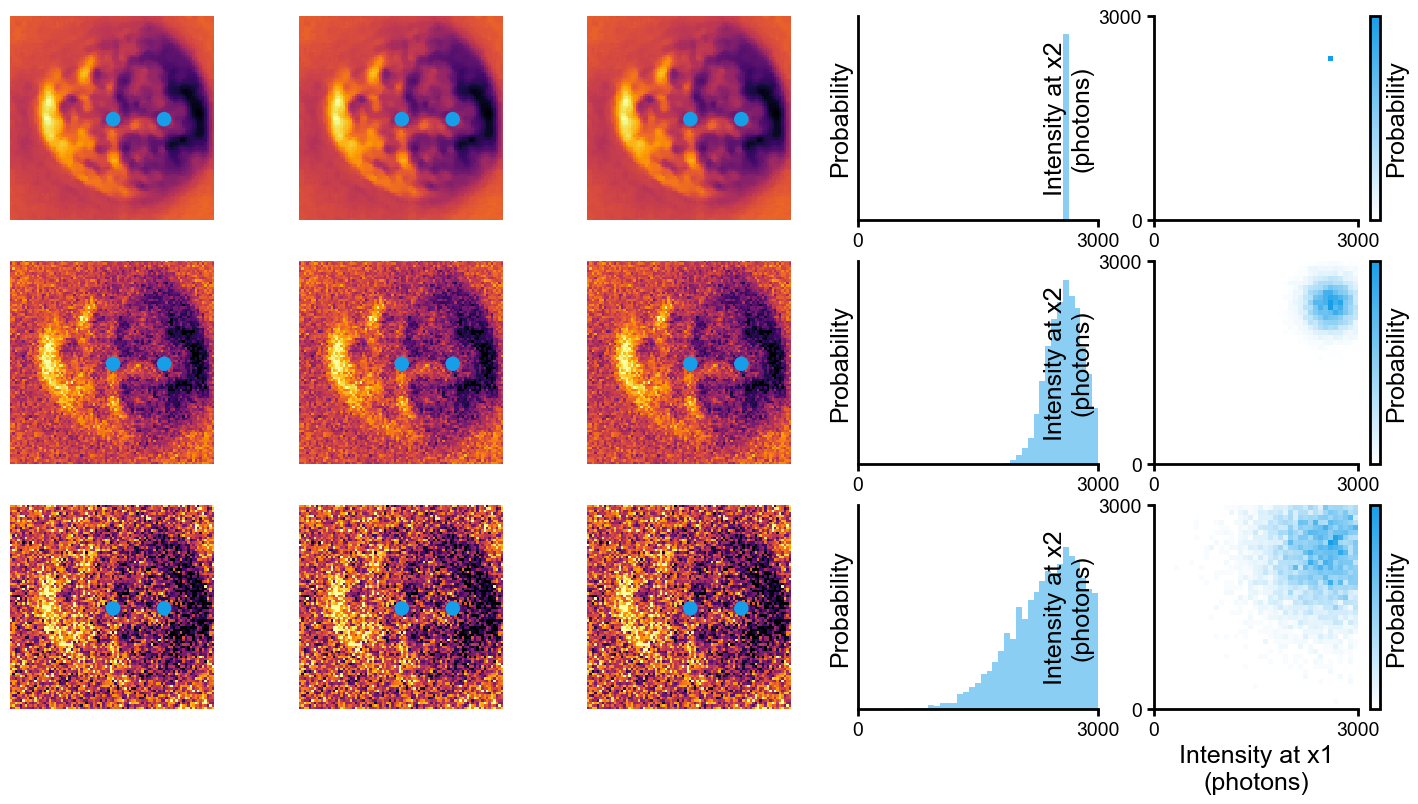

In [22]:
N_noisy = 10000

color = get_color_cycle()[0]
# color = np.array([86, 143, 193]) / 255
# color = np.array([157, 195, 219]) / 255

intensity_space_max = 3000
bins = np.linspace(0, intensity_space_max, 42)
# bins = 50

# Choose the index of the image you want to plot
index = 36
image = load_bsccm_images(bsccm, 'DPC_Right', indices=[index], convert_units_to_photons=True, median_filter=True, edge_crop=22)[0]

vmin = np.percentile(image, 0)
vmax = np.percentile(image, 100)


point2_offset = (10, 0)    
pixel1_center = np.array((image.shape[0] // 2 - point2_offset[0] // 2 , 
                            image.shape[0] // 2 - point2_offset[1] // 2)).astype(int)
pixel2_center = np.array((image.shape[0] // 2 + point2_offset[0] // 2, 
                            image.shape[0] // 2 + point2_offset[1] // 2 )).astype(int)
cmap = LinearSegmentedColormap.from_list(f'cmap', [(1,1,1), color])

fig, ax = plt.subplots(3, 5, figsize=(18,9))

for i, noise in enumerate(np.array([ 0, 240, 600])):
    # make 2000 noisy realizations of the image
    # noisy_images = np.array([simulate_shot_noise(image, fraction) for i in tqdm(range(M))]) / fraction 
    # gaussian noise
    noisy_images = onp.array([image + onp.random.normal(scale=noise, size=image.shape) for i in tqdm(range(N_noisy))])
    center_intensities_noisy = noisy_images[:, pixel1_center[1], pixel1_center[0]]
    three_quarter_intensities_noisy = noisy_images[:, pixel2_center[1], pixel2_center[0]]
    # plot the first image
    for j in range(3):
        img = noisy_images[i]
        ax[i, j].imshow(img, cmap='inferno', vmin=vmin, vmax=vmax, interpolation='nearest')
        ax[i, j].set_axis_off()
        # make a patch to show the center circle
        # Create a circle at the center of the image
        center_circle = patches.Circle((img.shape[1]//2, img.shape[0]//2), 
                                    radius=3, edgecolor='none', facecolor=color)

        # Create a circle 3/4 of the way along the image
        three_quarter_circle = patches.Circle((img.shape[1]*3//4, img.shape[0]//2), 
                                            radius=3, edgecolor='none', facecolor=color)

        # Add the patches to the Axes
        ax[i, j].add_patch(center_circle)
        ax[i, j].add_patch(three_quarter_circle)


    # make a 1d histogram of the center intensities
    ax[i, -2].hist(center_intensities_noisy, bins=bins, color=color, alpha=0.5, density=True)
    ax[i, -2].set(ylabel='Probability')
    
    ax[i, -2].set_xlim(0, intensity_space_max)
    default_format(ax[i, -2])
    ax[i, -2].set_yticks([])


    # make bins running from 0 to the max value of both intensities
    h = ax[i, -1].hist2d(center_intensities_noisy, three_quarter_intensities_noisy, bins=bins, cmap=cmap, density=True, vmin=0)
    ax[i, -1].set(ylabel='Intensity at x2\n(photons)')
    if i == 2:
        ax[i, -1].set(xlabel='Intensity at x1\n(photons)')
    # make axes square
    ax[i, -1].set_aspect('equal')
    default_format(ax[i, -1])
    # show colorbar with label "probability" and no ticks
    cbar = plt.colorbar(h[3], ax=ax[i, -1], label='Probability', fraction=0.07)
    cbar.ax.set_yticks([])


fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'noisy_realizations_of_image_level' + '.pdf', transparent=True, dpi=600)

# Generate bandlimited white noise

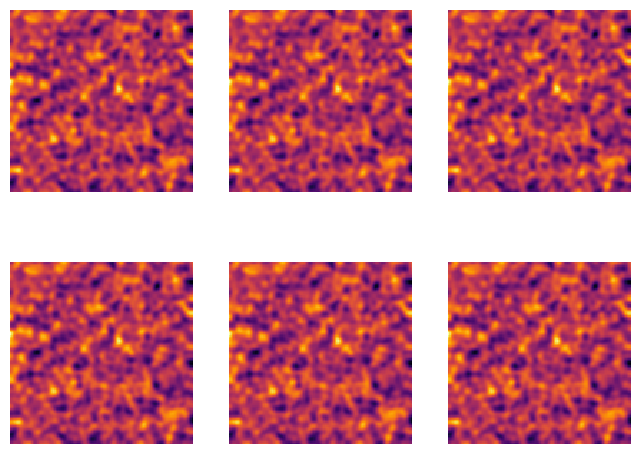

In [30]:
from scipy.ndimage import gaussian_filter
# Generate 3 128x128 bandlimited noise images and save them to a 3x1 figure

images = []
for i in range(3):
    images.append([])
    for j in range(2):
        image = np.random.normal(size=(128, 128))
        # apply a gaussian filter to the image
        image = gaussian_filter(image, sigma=2)
        images[-1].append(image)

fig, ax = plt.subplots(2, 3, figsize=(8, 6))
for i in range(3):
    for j in range(2):
        images[i][j]
        # plot
        ax[j, i].imshow(image, cmap='inferno', interpolation='nearest')
        ax[j, i].set_axis_off()

fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'bandlimited_noise' + '.pdf', transparent=True, dpi=600)

# Show the distribution of noisy and noiselesss images

In [33]:
N_noisy = 5
N_images = 2000
N_patches = 1000
x2_offset = (3, 0)
x2_offset = (5, 0)
x2_offset = (7, 0)


# photons_per_pixel = 100
# channel = 'LED119'
# intensity_space_max = 1000 * photon_fraction

photons_per_pixel = 60
channel = 'DPC_Right'
intensity_space_max = 100


current_photons_per_pixel = np.mean([convert_to_photons(bsccm.read_image(index, channel), 
                                                        **bsccm.global_metadata['led_array']['camera']) for index in range(50)])
photon_fraction = photons_per_pixel / current_photons_per_pixel


x1 = []
x2 = []
x1_noisy = []
x2_noisy = []
# Choose the index of the image you want to plot
for index in tqdm(range(N_images)):
    image = load_bsccm_images(bsccm, channel, indices=[index], convert_units_to_photons=True, median_filter=True)[0]
    image *= photon_fraction
    x1_val = image[image.shape[0] // 2, image.shape[1] // 2]
    x2_val = image[image.shape[0] // 2 + x2_offset[0], image.shape[1] // 2 + x2_offset[1]]
    x1.append(x1_val)
    x2.append(x2_val)
    x1_noisy.extend(np.random.poisson(x1_val, size=N_noisy))
    x2_noisy.extend(np.random.poisson(x2_val, size=N_noisy))

    # for i in range(N_patches):
    #     # generate a random point in the image
    #     center = (np.random.randint(36, 92), np.random.randint(36, 92))
    #     x1_val = filtered_image[filtered_image.shape[0] // 2, filtered_image.shape[1] // 2]
    #     x2_val = filtered_image[filtered_image.shape[0] // 2 + x2_offset[0], filtered_image.shape[1] // 2 + x2_offset[1]]    
    #     if center[0] + x2_offset[0] < filtered_image.shape[0] and center[1] + x2_offset[1] < filtered_image.shape[1]:
    #         x1.append(x1_val)
    #         x2.append(x2_val)
    #         x1_noisy.extend(np.random.poisson(x1_val, size=N_noisy))
    #         x2_noisy.extend(np.random.poisson(x2_val, size=N_noisy))

x1 = np.array(x1).ravel()
x2 = np.array(x2).ravel()
x1_noisy = np.array(x1_noisy).ravel()
x2_noisy = np.array(x2_noisy).ravel()

100%|██████████| 2000/2000 [00:06<00:00, 329.36it/s]


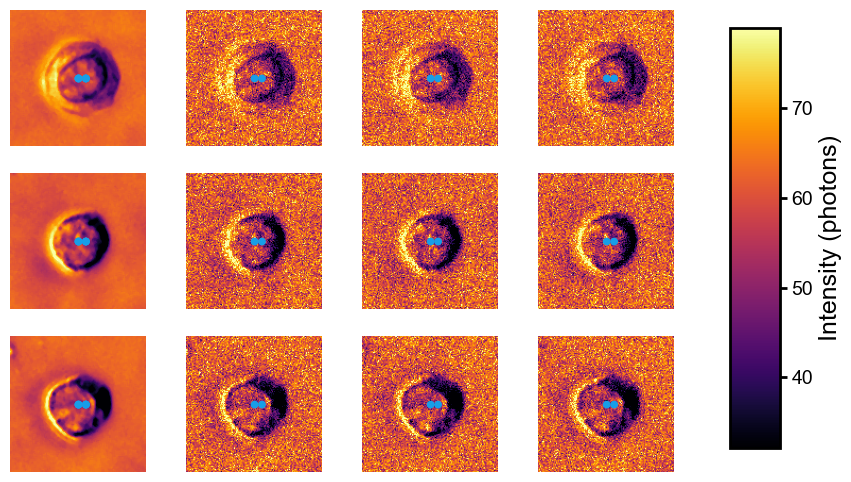

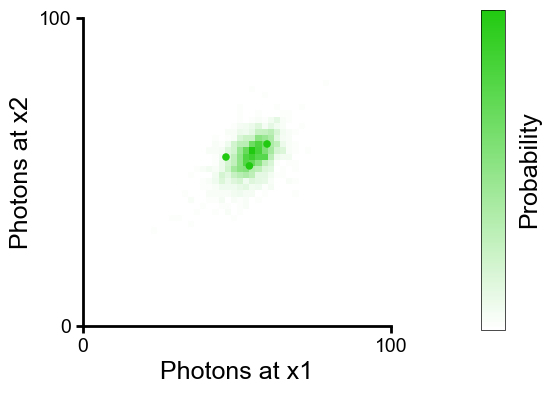

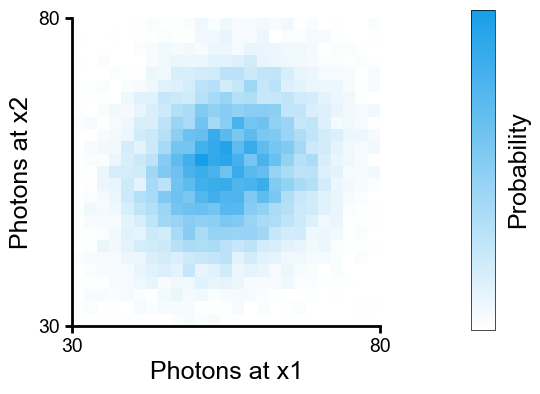

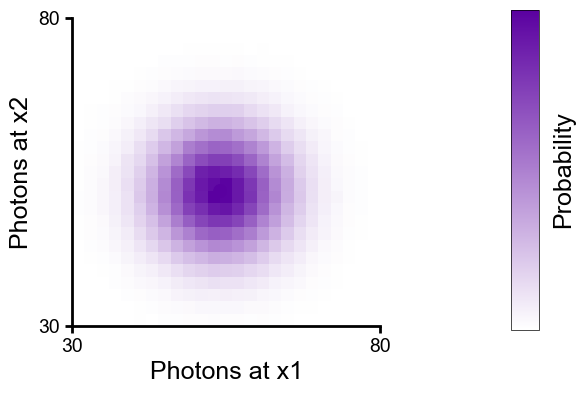

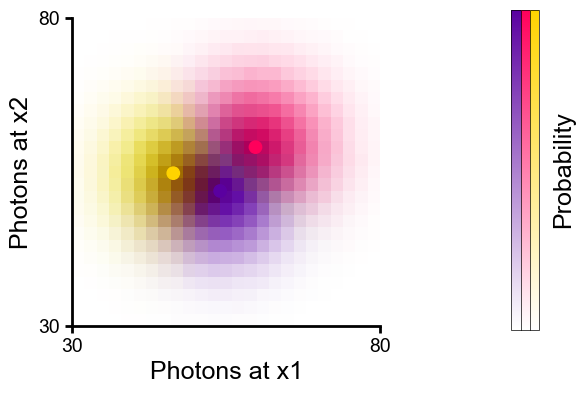

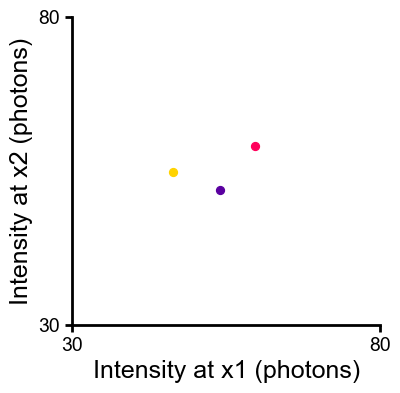

In [46]:
indices = [37, 24, 0]
indices = [21, 36, 115] # These look different


bins = 51
display_lim = (30, 80)

# plot 3 example filtered images and noisy images
images = load_bsccm_images(bsccm, channel, indices=indices, convert_units_to_photons=True, median_filter=False)
noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photon_fraction)

vmin = np.percentile(noisy_images, 1)
vmax = np.percentile(noisy_images, 99)

fig, ax = plt.subplots(3, 4, figsize=(10, 6))
image_x1s = []
image_x2s = []
for i, index in enumerate([0, 1, 2]):
    image = load_bsccm_images(bsccm, channel, indices=[index], convert_units_to_photons=True, median_filter=True)[0]
    image *= photon_fraction
    image_x1s.append(image[image.shape[0] // 2, image.shape[1] // 2])
    image_x2s.append(image[image.shape[0] // 2 + x2_offset[0], image.shape[1] // 2 + x2_offset[1]])
    im = ax[i, 0].imshow(image, cmap='inferno', vmin=vmin, vmax=vmax)
    ax[i, 0].axis('off')
    for k in range(3):
        ax[i, 1 + k].imshow(np.random.poisson(image), cmap='inferno', vmin=vmin, vmax=vmax)
        ax[i, 1 + k].axis('off')
        # plot circle patches at locations of x1 and x2
        for j, offset in enumerate([(0, 0), x2_offset]):
            color = get_color_cycle()[0]
            ax[i, 0].add_patch(Circle((image.shape[1] // 2 + offset[0], image.shape[0] // 2 + offset[1]), 3, color=color))
            ax[i, 1 + k].add_patch(Circle((image.shape[1] // 2 + offset[0], image.shape[0] // 2 + offset[1]), 3, color=color))
        
# add a colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Intensity (photons)')
fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'px_py_example_images' + '.pdf', transparent=True, dpi=600)

# plot intensity histogram of x1 and x2
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
cmap = LinearSegmentedColormap.from_list(f'cmap', [(1,1,1), get_color_cycle()[2]])
plot_intensity_coord_histogram(ax, x1, x2, intensity_space_max, cmap=cmap, bins=bins, 
                               plot_center_coords=np.stack([image_x1s, image_x2s], axis=1))

fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'p_x' + '.pdf', transparent=True, dpi=600)


# plot noisy x1 and x2
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
cmap = LinearSegmentedColormap.from_list(f'cmap', [(1,1,1), get_color_cycle()[0]])
plot_intensity_coord_histogram(ax, x1_noisy, x2_noisy, intensity_space_max, cmap=cmap, bins=bins)
ax.set(xlim=display_lim, ylim=display_lim, xticks=display_lim, yticks=display_lim)
fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'p_y' + '.pdf', transparent=True, dpi=600)



# # overlay the two
# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# colors = [get_color_cycle()[0], get_color_cycle()[2]]
# plot_intensity_coord_histogram(ax, [x1, x1_noisy[:x1.size]], [x2, x2_noisy[:x2.size]], intensity_space_max, 
#                                colors=colors, bins=bins)
# ax.set(xlim=display_lim, ylim=display_lim, xticks=display_lim, yticks=display_lim)
# fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'px_py_overlayed' + '.pdf', transparent=True, dpi=600)



# plot the poisson channel for the one points
x1_list = []
x2_list = []
N_noisy = 500000
x1_list.append(np.random.normal(loc=image_x1s[0], scale=np.sqrt(image_x1s[0]), size=N_noisy))
x2_list.append( np.random.normal(loc=image_x2s[0], scale=np.sqrt(image_x2s[0]), size=N_noisy))

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
colors = [get_color_cycle()[1]]
plot_intensity_coord_histogram(ax, x1_list, x2_list, intensity_space_max, 
                                    alpha=0.5, bins=bins, colors=colors, plot_center_coords=np.stack([image_x1s[:1], image_x2s[:1]], axis=1))                                    
ax.set(xlim=display_lim, ylim=display_lim, xticks=display_lim, yticks=display_lim)

fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'poisson_channel_same_color_1_points' + '.pdf', transparent=True, dpi=600)


# plot the poisson channel for the three points
x1_list = []
x2_list = []
N_noisy = 500000
for i, (image_x1, image_x2) in enumerate(zip(image_x1s, image_x2s)):
    x1_list.append(np.random.normal(loc=image_x1, scale=np.sqrt(image_x1), size=N_noisy))
    x2_list.append( np.random.normal(loc=image_x2, scale=np.sqrt(image_x2), size=N_noisy))



fig, ax = plt.subplots(1, 1, figsize=(7, 4))
colors = [get_color_cycle()[1], get_color_cycle()[3], get_color_cycle()[6]]
plot_intensity_coord_histogram(ax, x1_list, x2_list, intensity_space_max, 
                                    alpha=0.5, bins=bins, colors=colors, plot_center_coords=np.stack([image_x1s, image_x2s], axis=1))                                    
ax.set(xlim=display_lim, ylim=display_lim, xticks=display_lim, yticks=display_lim)

fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'poisson_channel_same_color_3_points' + '.pdf', transparent=True, dpi=600)

# make another plot that plots each point with a different color
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for (image_x1, image_x2), color in zip(zip(image_x1s, image_x2s), colors):
    ax.scatter(image_x1, image_x2, s=32, color=color, alpha=1)
default_format(ax)
ax.set(xlabel='Intensity at x1 (photons)', ylabel='Intensity at x2 (photons)')
ax.set(xlim=display_lim, ylim=display_lim, xticks=display_lim, yticks=display_lim)
ax.set_aspect('equal')
fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'poisson_channel_points_same_color_3_points' + '.pdf', transparent=True, dpi=600)



# Reverse perspective of p(X | Y)

In [49]:
N_images = 2000
x2_offset = (3, 0)
x2_offset = (5, 0)
x2_offset = (7, 0)

# photons_per_pixel = 100
# channel = 'LED119'
# intensity_space_max = 1000 * photon_fraction

photons_per_pixel = 60
channel = 'DPC_Right'
intensity_space_max = 100

current_photons_per_pixel = np.mean([convert_to_photons(bsccm.read_image(index, channel), 
                                                        **bsccm.global_metadata['led_array']['camera']) for index in range(50)])
photon_fraction = photons_per_pixel / current_photons_per_pixel

x1 = []
x2 = []
# Choose the index of the image you want to plot
for index in tqdm(range(N_images)):
    image = load_bsccm_images(bsccm, channel, indices=[index], convert_units_to_photons=True, median_filter=True)[0] * photon_fraction
    # filtered_image = image
    x1_val = image[image.shape[0] // 2, image.shape[1] // 2]
    x2_val = image[image.shape[0] // 2 + x2_offset[0], image.shape[1] // 2 + x2_offset[1]]
    x1.append(x1_val)
    x2.append(x2_val)

x1 = np.array(x1).ravel()
x2 = np.array(x2).ravel()

100%|██████████| 2000/2000 [00:06<00:00, 328.57it/s]


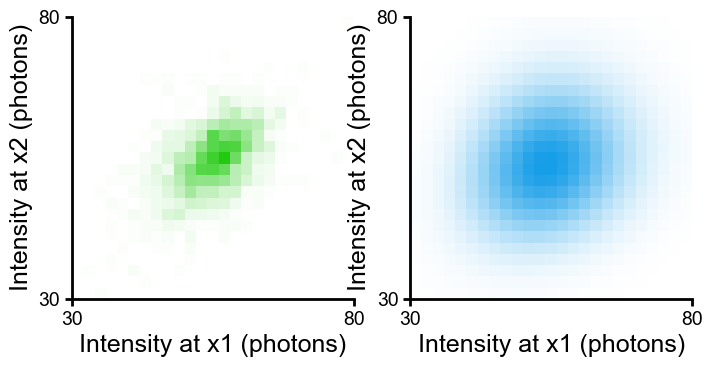

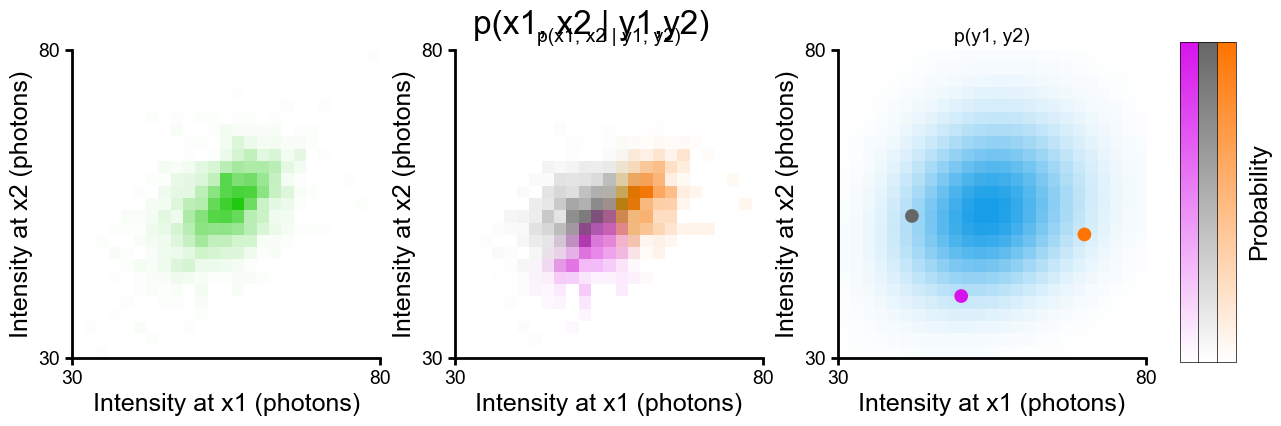

In [50]:
py_points = np.array([[40, 50],
                     [53, 42],
                     [50, 70]])

lims = np.array((30, 80))
colors = [get_color_cycle()[4], get_color_cycle()[5], get_color_cycle()[8]]


# Generate poisson channel matrix
x_support = np.arange(0, intensity_space_max, 2)
num_bins = 50
p_y_given_x = np.array([poisson.pmf(x, x_support) + poisson.pmf(x + 1, x_support) for x in x_support])
particular_x1_x2 = np.array([25, 30]) # 50, 60 photons


# normalize to account for higher counts than are measured
# p_y_given_x /= p_y_given_x.sum(axis=0, keepdims=True)


cmap_px = LinearSegmentedColormap.from_list(f'cmap', [(1,1,1), get_color_cycle()[2]])
cmap_py = LinearSegmentedColormap.from_list(f'cmap', [(1,1,1), get_color_cycle()[0]])

def show_log_prob(ax, p, title):
    ax.imshow(np.log(1e-2 + p), cmap=cmap, origin='lower') 
    ax.set_title(title)
    if p.shape[1] == 1:
        ax.set(xticks=[], yticks=[])
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)


# compute 2d histogram px 
bins = np.linspace(0, intensity_space_max, num_bins + 1)
p_x, yedges, xedges = np.histogram2d(x1, x2, bins=bins)
p_x /= p_x.sum()


# compute the 2d channel matrix
p_y1y2_given_x1x2 = jnp.kron(p_y_given_x, p_y_given_x)
# compute p_y
p_y = (p_y1y2_given_x1x2 @ p_x.ravel()).reshape(num_bins, num_bins)
# compute joint probability
p_y_x = p_y1y2_given_x1x2 @ jnp.diag(p_x.ravel())

# un-vectorize
p_y1y2_given_x1x2 = p_y1y2_given_x1x2.reshape(num_bins, num_bins, num_bins, num_bins)

format = lambda ax: (ax.set(xlim=lims, ylim=lims, xticks=lims, yticks=lims, 
                            xlabel='Intensity at x1 (photons)', ylabel='Intensity at x2 (photons)'
                            ), clear_spines(ax))

# show p_x and p_y (in 2d)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(p_x, cmap=cmap_px, origin='lower', extent=[0, intensity_space_max, 0, intensity_space_max])
format(ax[0])


ax[1].imshow(p_y, cmap=cmap_py, origin='lower', extent=[0, intensity_space_max, 0, intensity_space_max])
format(ax[1])

# show joint probability (Only works for small number of bins)
# fig, ax = plt.subplots(1, 3, figsize=(8, 4))
# show_log_prob(ax[0], p_y.reshape([-1, 1]), 'p_y')
# show_log_prob(ax[1], p_y1y2_given_x1x2, 'p_y1y2_given_x1x2')
# show_log_prob(ax[2], p_x.reshape([-1, 1]), 'p_x')


# show p_y in 2d for a particular x1, x2
# fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# ax[1].imshow(p_y1y2_given_x1x2[..., particular_x1_x2[0], particular_x1_x2[1]],
#               cmap=cmap, origin='lower', extent=[0, intensity_space_max, 0, intensity_space_max])
# ax[1].set_title('p(y1, y2 | x1, x2)')
# format(ax[1])

# particular_x1_x2_image = np.zeros((num_bins, num_bins))
# particular_x1_x2_image[particular_x1_x2[0], particular_x1_x2[1]] = 1
# ax[0].imshow(particular_x1_x2_image, cmap=cmap_px, origin='lower', extent=[0, intensity_space_max, 0, intensity_space_max])
# ax[0].set_title('p(x1, x2)')
# format(ax[0])
# fig.suptitle('p_y given a particular x1, x2')


p_x1x2_given_y1y2 = p_y_x.T @ np.diag(1 / ( 1e-20 + p_y.flatten()))
p_x1x2_given_y1y2 = p_x1x2_given_y1y2.reshape((num_bins, num_bins, num_bins, num_bins))


# show p_x1x2_given_y1y2 in 2d for a particular y1, y2
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0].imshow(p_x, cmap=cmap_px, origin='lower', extent=[0, intensity_space_max, 0, intensity_space_max])
format(ax[0])

# compute blended image
images = np.array([p_x1x2_given_y1y2[..., y_value[0] // 2, y_value[1] // 2] for y_value in py_points])
images /= np.max(images)
cmaps =  [LinearSegmentedColormap.from_list(f'cmap', [(1,1,1), color]) for color in colors]
blended_color = np.min(np.stack([cmap(hist) for cmap, hist in zip(cmaps, images)], axis=0), axis=0)
ax[1].imshow(blended_color , origin='lower', extent=[0, intensity_space_max, 0, intensity_space_max])
add_multiple_colorbars(ax[1], cmaps)



ax[1].set_title('p(x1, x2 | y1, y2)')
format(ax[1])

# plot p_y distribution
ax[2].imshow(p_y, cmap=cmap_py, origin='lower', extent=[0, intensity_space_max, 0, intensity_space_max])
format(ax[1])

# show mpl circles on top at each point


for y_value, c in zip(py_points, colors):
    y_index = y_value // 2
    # add patch
    ax[2].add_patch(Circle((y_value[1], y_value[0]), radius=1, color=c, fill=True, linewidth=1))    

ax[2].set_title('p(y1, y2)')
format(ax[2])
fig.suptitle('p(x1, x2 | y1,y2)')
fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'reverse_view_px_given_y' + '.pdf', transparent=True, dpi=600)


## Multiple columns of noiseless images

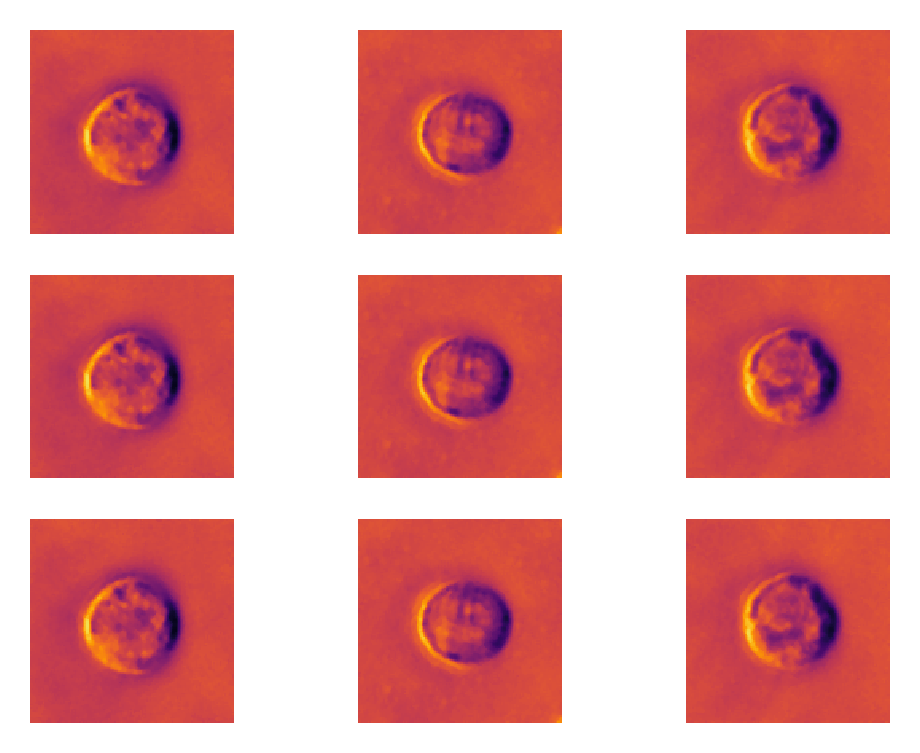

In [66]:
indices = [21, 36, 115] # these have images that look different
num_similar_images = 3

def find_most_similar_indices(test_image, images):
    # compute the similarity between the test image and all other images
    dist = np.sum((test_image[None] - np.array(images)) ** 2, axis=(1, 2))
    min_dist_indices = np.argsort(dist)
    return min_dist_indices


# read the three images in DPC_Right contrast
images = load_bsccm_images(bsccm, 'DPC_Right', indices=range(500), convert_units_to_photons=True, median_filter=True)

# get vmin and vmax for all images
vmin = np.min(images)
vmax = np.max(images)

# make a 3 x4 plot
fig, ax = plt.subplots(len(indices), num_similar_images, figsize=(4, len(indices)), dpi=300)
# first column in noiseless images
for i in range(len(indices)):
    similar_indices = find_most_similar_indices(image, images)
    for j in range(num_similar_images):
        ax[i, j].imshow(images[similar_indices[j]], cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax)
        ax[i, j].axis('off')
        

fig.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'multiple_noiseless_images' + '.pdf', transparent=True, dpi=600)